This is a project to classify spam and ham messages using LSTM. This is a basic and simple model that will take one through a detailed steps to approach a NLP problem.

**Steps involved in the Project:**

*  **Data Cleaning:**
1. Removing unwanted columns.
2. Exploring & comparing length of messages.
3. Performing undersampling on dataset.

* **Text preparation:**
1. Tokenization of Messages.
2. One hot implementation on tokenized message(corpus)
3. Perform word embedding

* **Data preparation/Data Splitting:**
1. Split the data into training+validation(85%) & testing(15%) data.
2. Further split the training+validation data into training(85%) and validation(15%) data.

* **Model Building:**
1. Build a Sequential model: Embedding Layer->LSTM->Dense(output layer)
2. Fit and Validate model on training and validation model

* **Model Evaluation:**
1. Evaluate the model on test dataset.
2. Get the model accuracy score and visualize confusion matrix


* **Model Testing:**
1. Created a function that would classifiy the messages using the model


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import seaborn and matplotlib for visualization

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Read the .csv file and display the first entries of the data

In [3]:
data = pd.read_csv("spam.csv", encoding="latin")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The dataset contains 5 columns of which 3 Unnamed columns are not important for us

In [4]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Drop these three columns

In [5]:
data = data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

columns **v1** & **v2** does not make any sense so rename the columns into meaningful **Category** & **Message** names

In [6]:
data = data.rename(
    {
        "v1": "Category",
        "v2": "Message"
    },
    axis=1
)

Display head of the new dataset

In [7]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Check if the dataset contains any **null** values, luckily we got dataset without any null values

In [8]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Create new column called **Message Length** that would compute the message lengths

In [10]:
data["Message Length"] = data["Message"].apply(len)

**Visualize** the Messages length using **histogram**

It is evident form the plot that **spam** messages on an average are usually **lengthier** than the **non-spam(ham)** messages.

c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


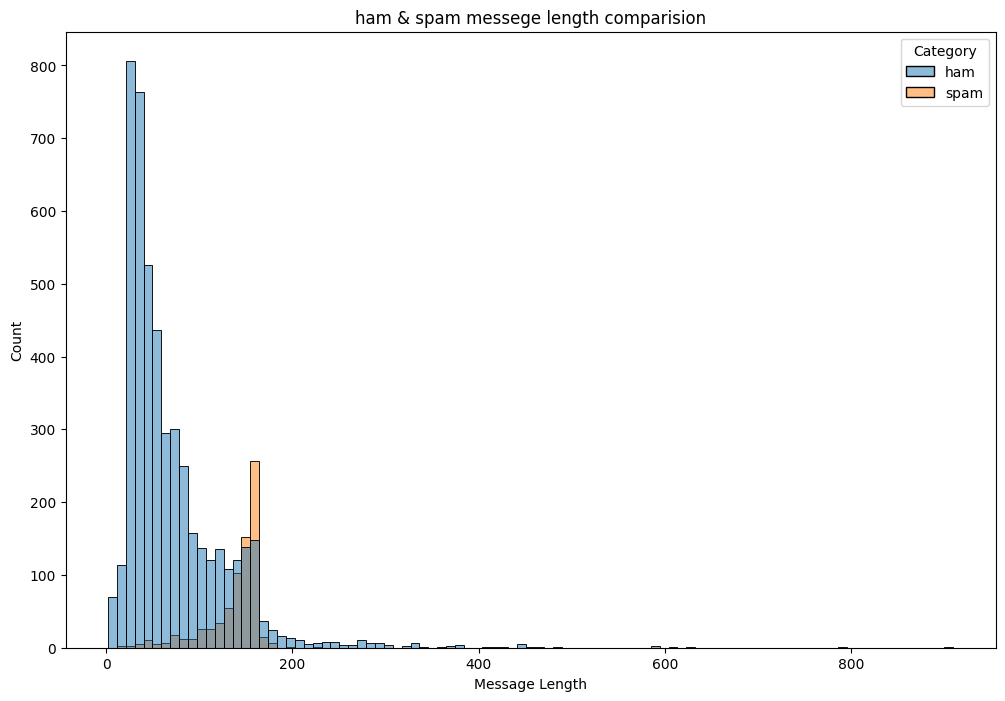

In [11]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

Display the **description** of length of **ham** and **spam** messages seperately on an individual series.

From the statistics of the two description we can see that the ham contains the longest message of 910 length. However more than 70% of the ham messages contains messages of length less than 90.

On the other hand 75% spam messages have messages length more than 130. Hence can conclude than the spam messages are usually lenthier 

In [12]:
ham_desc = data[data["Category"] == "ham"]["Message Length"].describe()
spam_desc = data[data["Category"] == "spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n", ham_desc)
print("************************************")
print("Spam Message Length Description:\n", spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


From the overall data Description we knew that label **Category** contains 2 unique values and hence is a categorical variable and a binary classification problem

In [13]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


The two unique values are **ham** & **spam** and **ham** contains **4825** & **spam** with **747** entries which is a vast difference

In [14]:
data["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

Visualizing the **Category** using countplot shows our **spam** messages are relatively less compared to the **ham** messages in the dataset

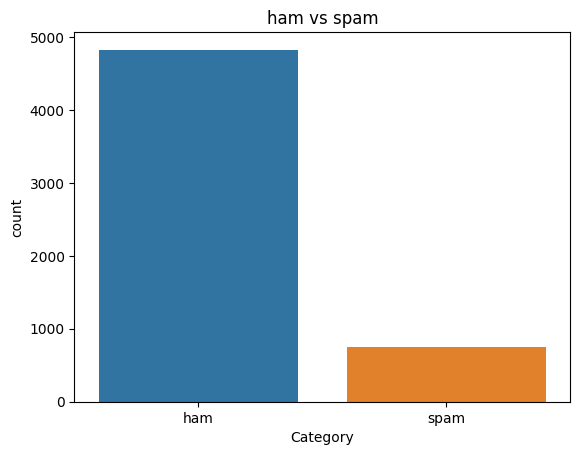

In [15]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

**Ham** contains **86.6%** while **spam** constitute only **13.4%** of the total dataset, and thus we can conclude that the data is **imbalanced**.

**Imbalanced Data:** Imbalanced data are dataset with an unequal class distribution. Since the ham contains more than 86% of dataset, the model can plainly have an accuracy score of **86%** by just classifying all the entries as ham message. However we just dont want to have a more accuracy score but also a model that can **generalize** well.



In [16]:
ham_count = data["Category"].value_counts()[0]
spam_count = data["Category"].value_counts()[1]

total_count = data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(
    spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


C:\Users\Home\AppData\Local\Temp\ipykernel_8440\2866307372.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ham_count = data["Category"].value_counts()[0]
C:\Users\Home\AppData\Local\Temp\ipykernel_8440\2866307372.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spam_count = data["Category"].value_counts()[1]


Since our dataset is imbalanced I have used undersampling technique to make a balanced dataset.

**Undersampling**: It is a technique of obtaining an equivalent sample from the dataset by simply **deleting** some of the examples of **majority** class

In [17]:
# compute the length of majority & minority class
minority_len = len(data[data["Category"] == "spam"])
majority_len = len(data[data["Category"] == "ham"])

# store the indices of majority and minority class
minority_indices = data[data["Category"] == "spam"].index
majority_indices = data[data["Category"] == "ham"].index

# generate new majority indices from the total majority_indices
# with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices = np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

# concatenate the two indices to obtain indices of new dataframe
undersampled_indices = np.concatenate(
    [minority_indices, random_majority_indices])

# create df using new indices
df = data.loc[undersampled_indices]

# shuffle the sample
df = df.sample(frac=1)

# reset the index as its all mixed
df = df.reset_index()

# drop the older index
df = df.drop(
    columns=["index"],
)

The resulting dataframes have **1494** rows and **4** columns 

In [18]:
df.shape

(1494, 3)

Now we can see that the category cotains **747** entries for **ham** and **spam** and now we have a **balanced** dataset.

In [19]:
df["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

Both **ham** and **spam** message bars are now **equal** and hence obtained a **balanced** dataset.

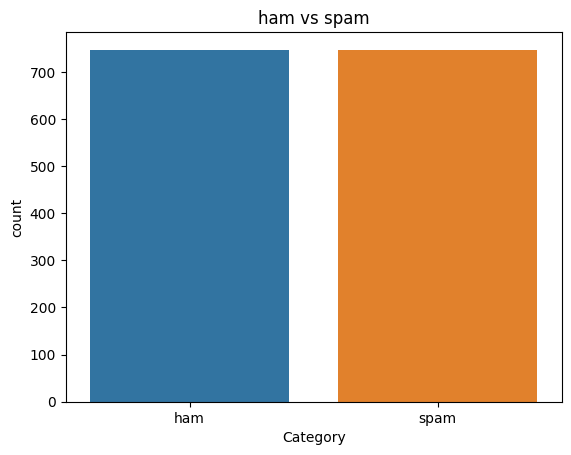

In [20]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

Display the head of new **df**

In [21]:
df.head()

,Category,Message,Message Length
0,ham,WHORE YOU ARE UNBELIEVABLE.,27
1,ham,"The house is on the water with a dock, a boat ...",116
2,spam,Dorothy@kiefer.com (Bank of Granite issues Str...,156
3,ham,"Japanese Proverb: If one Can do it, U too Can ...",276
4,spam,Our brand new mobile music service is now live...,157


Created new column **Label** and encode **ham** as **0** and **spam** as **1**

In [22]:
df["Label"] = df["Category"].map(
    {
        "ham": 0,
        "spam": 1
    }
)

display head to see the new column

In [23]:
df.head()

,Category,Message,Message Length,Label
0,ham,WHORE YOU ARE UNBELIEVABLE.,27,0
1,ham,"The house is on the water with a dock, a boat ...",116,0
2,spam,Dorothy@kiefer.com (Bank of Granite issues Str...,156,1
3,ham,"Japanese Proverb: If one Can do it, U too Can ...",276,0
4,spam,Our brand new mobile music service is now live...,157,1


Import libraries to perform word **tokenization**

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

Perform word **tokenization** using the below block of code

In [25]:
# declare empty list to store tokenized message
corpus = []

# iterate through the df["Message"]
for message in df["Message"]:

    # replace every special characters, numbers etc.. with whitespace of message
    # It will help retain only letter/alphabets
    message = re.sub("[^a-zA-Z]", " ", message)

    # convert every letters to its lowercase
    message = message.lower()

    # split the word into individual word list
    message = message.split()

    # perform stemming using PorterStemmer for all non-english-stopwords
    message = [stemmer.stem(words)
               for words in message
               if words not in set(stopwords.words("english"))
               ]
    # join the word lists with the whitespace
    message = " ".join(message)

    # append the message in corpus list
    corpus.append(message)

Perform one_hot on the corpus

I have initialized the **vocabulary** size to **10,000.**

**oneHot_doc** will contain the list of indices of words in the corpus whose indices will range in bw **0-10,000**.

In [26]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 10000

oneHot_doc = [one_hot(words, n=vocab_size)
              for words in corpus
              ]

After **one_hot** we will then perform **word embedding** 

The resulting list of one_hot will contain uneven indices length because of uneven length of tokenized words in the corpus.

To perform word embedding we have to consider a sentence length and hence to define a fixed sentence length for our dataset we will try to visualize and understand the patterns of Messege length of dataset.

In [27]:
df["Message Length"].describe()

count    1494.000000
mean      105.286479
std        53.535982
min         2.000000
25%        51.000000
50%       120.000000
75%       153.000000
max       363.000000
Name: Message Length, dtype: float64

**visualizing the Messages length using kdeplot.**

From the plot we can see that spam messages usually are lengthier than ham messages, however both the messages are concentrated bw the lenth of 0-200, of course there are few messages with lengths more than 200. However we will take a length of 200 to make an even distribution amongst the two messages.

c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


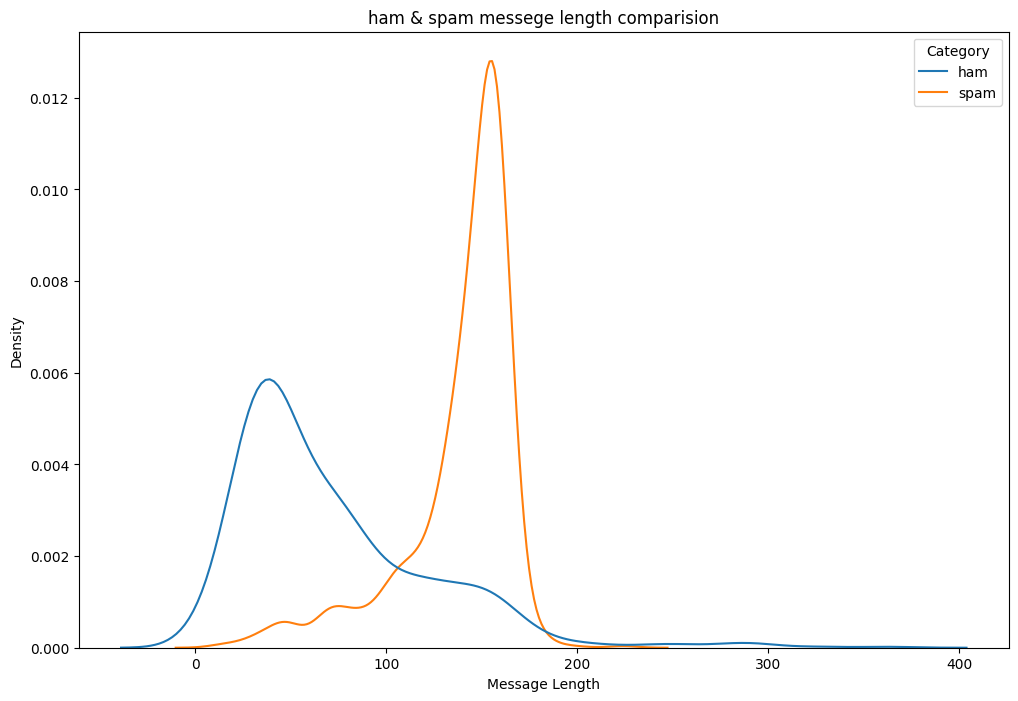

In [28]:
fig = plt.figure(figsize=(12, 8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

We will use **pad_sequences** from keras to perform **word embedding**.

This will make every list to an equal length(**sentence length**) which we can later be fed to our model.

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len = 200
embedded_doc = pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

Let us make a data frame using embedded document, and a target using **Label** column from df

In [30]:
extract_features = pd.DataFrame(
    data=embedded_doc
)
target = df["Label"]

I have concatenated two dataframes to get the final dataframe

In [31]:
df_final = pd.concat([extract_features, target], axis=1)

The Resulting dataframe contains 201 columns where 200 are independent features and 1 is our target class.

In [32]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8860,6327,0
1,0,0,0,0,0,0,0,0,0,0,...,9787,7486,92,1706,4577,9987,2138,2273,6488,0
2,0,0,0,0,0,0,0,0,0,0,...,1857,7647,5283,8133,3316,4398,7238,1441,5439,1
3,0,0,0,0,0,0,0,0,0,0,...,4007,2322,6474,3295,3280,6315,8657,7512,4131,0
4,0,0,0,0,0,0,0,0,0,0,...,7817,9369,778,350,8602,7891,312,7585,1950,1


Split the dataframe into **dependent(y)** & **independent(X)** variables 

In [33]:
X = df_final.drop("Label", axis=1)
y = df_final["Label"]

We will now split the dataset for **training**,**validataing** and **testing** sets.

In [34]:
from sklearn.model_selection import train_test_split

The code will split the whole data into two parts **trainval** & **testing**.

**Trainval** dataset will contain the dataset for training and validation sets, which will constitute 85% of the data and rest as test data(15%).

This is done so to stop **data leakage**. If we use test data as both validation and testing purpose its very likely that our model will just **memorize** the dataset while validating using test data and we will get a **overfitted model**.

So I just wanted to completely **isolate** the **test** data from **train** and **validation** dataset, so we get a model with better **generilization**.

In [35]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

We have splitted **85**% dataset into **training** and **validataion** so lets futher split our **trainval** data into **training**(**85**%) and **validation**(**15**%) dataset.

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)

import libraries to create **model**

In [37]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

Initialize the **Sequential** model

In [38]:
model = Sequential()

create a model using **Embedding layer->LSTM->Dense**

**Embedding_layer**: We will declare input_dimesion as our vocaburaly size(10,000),input_length as the sentence length and output dimension as 100.

**LSTM**: Add **128** units to the layers whose output will be fed as an input to our output Dense layer.

**Dense**: Add 1 unit(neurons) to the dense layers and with an **sigmoid** activation, since we have binary classification problem. Else if you are to performing multi-class classification problem **softmax** activation with **units=no. of classes** would perform pretty well.

In [39]:
feature_num = 100
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=feature_num,
        input_length=sentence_len
    )
)
model.add(
    LSTM(
        units=128
    )
)

model.add(
    Dense(
        units=1,
        activation="sigmoid"
    )
)

Lets **compile** the model built above.

I have used a **adam** optimizer with **learning rate of 0.001** & **binary_crossentropy** as loss funtion

In [40]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(
        learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Once the model is complied we will **fit** the model using **train** and **validation** dataset.

In [41]:
model.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=10
)

Epoch 1/10
34/34 [==============================] - 7s 153ms/step - loss: 0.5131 - accuracy: 0.8080 - val_loss: 0.3343 - val_accuracy: 0.8848
Epoch 2/10
34/34 [==============================] - 6s 179ms/step - loss: 0.1745 - accuracy: 0.9443 - val_loss: 0.1417 - val_accuracy: 0.9581
Epoch 3/10
34/34 [==============================] - 4s 130ms/step - loss: 0.0633 - accuracy: 0.9777 - val_loss: 0.1269 - val_accuracy: 0.9529
Epoch 4/10
34/34 [==============================] - 4s 131ms/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.0865 - val_accuracy: 0.9738
Epoch 5/10
34/34 [==============================] - 5s 133ms/step - loss: 0.7993 - accuracy: 0.8785 - val_loss: 0.3068 - val_accuracy: 0.8796
Epoch 6/10
34/34 [==============================] - 5s 138ms/step - loss: 0.1032 - accuracy: 0.9842 - val_loss: 0.1409 - val_accuracy: 0.9319
Epoch 7/10
34/34 [==============================] - 5s 143ms/step - loss: 0.0283 - accuracy: 0.9963 - val_loss: 0.1196 - val_accuracy: 0.9476
Epoch 

Since the model is fitted using required datasets, its time that how our model predict test data we have isolated earlier.

The prediction will be stored in array of boolean where prediction value **greater than** **0.5** will be assigned **True(Spam)** else **lesser than 0.5 will be False(Ham)**

In [42]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

8/8 [==============================] - 1s 39ms/step


In [44]:
from sklearn.metrics import precision_score, recall_score

# Assuming your model has been trained and evaluated on test data X_test and y_test

# Make predictions on test data
y_pred = model.predict(X_test)

# Convert probability predictions to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)

8/8 [==============================] - 0s 38ms/step
Precision: 0.9814814814814815
Recall: 0.9724770642201835


Lets import **metrics** to **evaluate** our **model**

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix

The model predicts pretty well on the **test** data as evident from the accuracy score.

In [44]:
score = accuracy_score(y_test, y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:94.22%


Lets **visualize** our **confusion_matrix** using **heatmap**

Our Model also gives a better generalization since the number of **False Positive(FP)** and **False Negative(FN)** are relatively lesser than the **True Postive(TP)** and **True Negative(TN)**

array([[ 93,  10],
       [  3, 119]], dtype=int64)

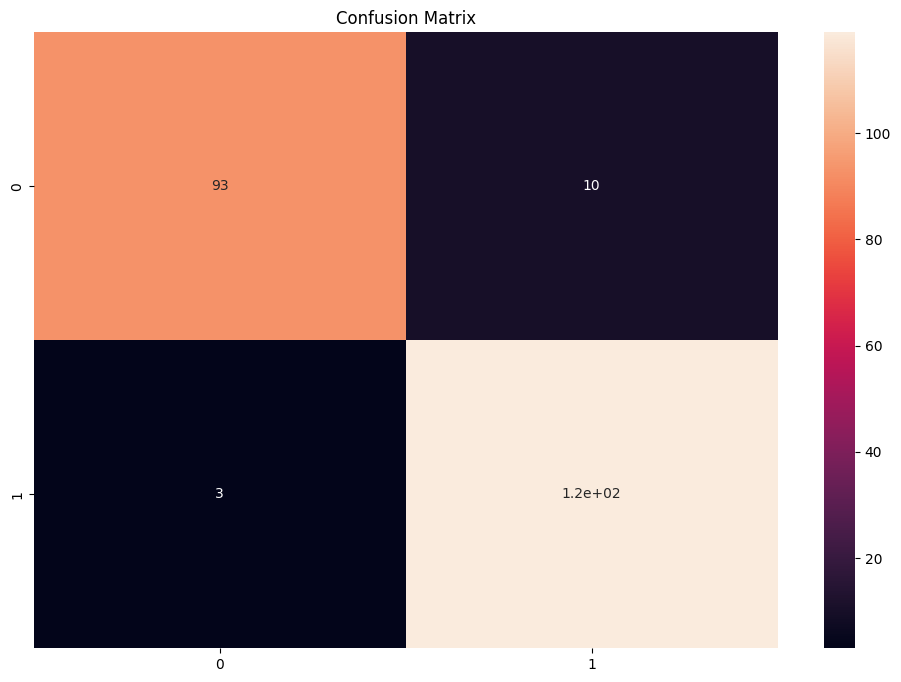

In [45]:
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

This is the final code(**function**) that would take a **raw message** and classfiy the message using the model.

In [46]:
# The function take model and message as parameter
def classify_message(model, message):

    # We will treat message as a paragraphs containing multiple sentences(lines)
    # we will extract individual lines
    for sentences in message:
        sentences = nltk.sent_tokenize(message)

        # Iterate over individual sentences
        for sentence in sentences:
            # replace all special characters
            words = re.sub("[^a-zA-Z]", " ", sentence)

            # perform word tokenization of all non-english-stopwords
            if words not in set(stopwords.words('english')):
                word = nltk.word_tokenize(words)
                word = " ".join(word)

    # perform one_hot on tokenized word
    oneHot = [one_hot(word, n=vocab_size)]

    # create an embedded documnet using pad_sequences
    # this can be fed to our model
    text = pad_sequences(oneHot, maxlen=sentence_len, padding="pre")

    # predict the text using model
    predict = model.predict(text)

    # if predict value is greater than 0.5 its a spam
    if predict > 0.5:
        print("It is a spam")
    # else the message is not a spam
    else:
        print("It is not a spam")

In [50]:
text1 = "I am having a bad day and I would like to have a break today"
text2 = "This is to inform you had won a lottery and the subscription will end in a week so call us."

The model predicts **message1** as **not a spam message**

In [51]:
classify_message(model, text1)

1/1 [==============================] - 0s 45ms/step
It is not a spam


The model predicts **message2** as **spam message**

In [52]:
classify_message(model, text2)

1/1 [==============================] - 0s 51ms/step
It is a spam


In [54]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv("spam.csv", encoding="latin")

# Rename columns
data = data.rename(columns={"v1": "Category", "v2": "Message"})

# Preprocess the text data
stemmer = PorterStemmer()
corpus = []
for message in data["Message"]:
    message = re.sub("[^a-zA-Z]", " ", message)
    message = message.lower()
    message = message.split()
    message = [stemmer.stem(word) for word in message if word not in set(
        stopwords.words("english"))]
    message = " ".join(message)
    corpus.append(message)

# Encode labels
label_encoder = LabelEncoder()
data["Category"] = label_encoder.fit_transform(data["Category"])

# Perform one-hot encoding for the text data
vocab_size = 10000
oneHot_doc = [one_hot(words, n=vocab_size) for words in corpus]

# Pad sequences to ensure uniform length
sentence_len = 200
embedded_doc = pad_sequences(oneHot_doc, maxlen=sentence_len, padding="pre")

# Split data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
    embedded_doc, data["Category"], random_state=42, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, random_state=42, test_size=0.15)

# Build the model
model = Sequential()
feature_num = 100
model.add(Embedding(input_dim=vocab_size,
          output_dim=feature_num, input_length=sentence_len))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
126/126 [==============================] - 44s 319ms/step - loss: 0.1763 - accuracy: 0.9416 - val_loss: 0.0710 - val_accuracy: 0.9761
Epoch 2/10
126/126 [==============================] - 36s 288ms/step - loss: 0.0387 - accuracy: 0.9891 - val_loss: 0.0736 - val_accuracy: 0.9873
Epoch 3/10
126/126 [==============================] - 33s 266ms/step - loss: 0.0255 - accuracy: 0.9943 - val_loss: 0.0609 - val_accuracy: 0.9873
Epoch 4/10
126/126 [==============================] - 34s 272ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0670 - val_accuracy: 0.9845
Epoch 5/10
126/126 [==============================] - 36s 282ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.0726 - val_accuracy: 0.9859
Epoch 6/10
126/126 [==============================] - 34s 269ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0740 - val_accuracy: 0.9859
Epoch 7/10
126/126 [==============================] - 44s 352ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0807 - val_ac

27/27 [==============================] - 2s 59ms/step
Test Score:98.44%


array([[720,   8],
       [  5, 103]], dtype=int64)

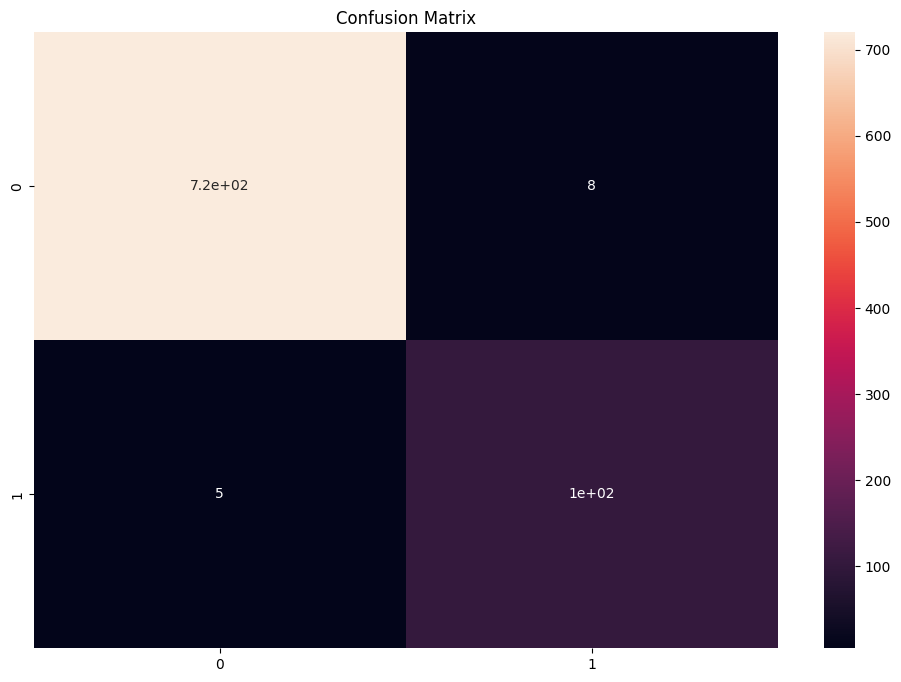

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

score = accuracy_score(y_test, y_pred)
print("Test Score:{:.2f}%".format(score*100))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

In [56]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv("spam.csv", encoding="latin")

# Rename columns
data = data.rename(columns={"v1": "Category", "v2": "Message"})

# Preprocess the text data
stemmer = PorterStemmer()
corpus = []
for message in data["Message"]:
    message = re.sub("[^a-zA-Z]", " ", message)
    message = message.lower()
    message = message.split()
    message = [stemmer.stem(word) for word in message if word not in set(
        stopwords.words("english"))]
    message = " ".join(message)
    corpus.append(message)

# Encode labels
label_encoder = LabelEncoder()
data["Category"] = label_encoder.fit_transform(data["Category"])

# Perform one-hot encoding for the text data
vocab_size = 10000
oneHot_doc = [one_hot(words, n=vocab_size) for words in corpus]

# Pad sequences to ensure uniform length
sentence_len = 200
embedded_doc = pad_sequences(oneHot_doc, maxlen=sentence_len, padding="pre")

# Split data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
    embedded_doc, data["Category"], random_state=42, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, random_state=42, test_size=0.15)

# Build the model
model = Sequential()
feature_num = 100
model.add(Embedding(input_dim=vocab_size,
          output_dim=feature_num, input_length=sentence_len))
model.add(Bidirectional(GRU(units=128)))
model.add(Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/3
126/126 [==============================] - 41s 295ms/step - loss: 0.1832 - accuracy: 0.9322 - val_loss: 0.0821 - val_accuracy: 0.9775
Epoch 2/3
126/126 [==============================] - 31s 246ms/step - loss: 0.0270 - accuracy: 0.9923 - val_loss: 0.0636 - val_accuracy: 0.9859
Epoch 3/3
27/27 [==============================] - 1s 40ms/step - loss: 0.0379 - accuracy: 0.9916
Test Loss: 0.037931013852357864
Test Accuracy: 0.9916267991065979


27/27 [==============================] - 2s 46ms/step
Test Score:99.16%


array([[725,   3],
       [  4, 104]], dtype=int64)

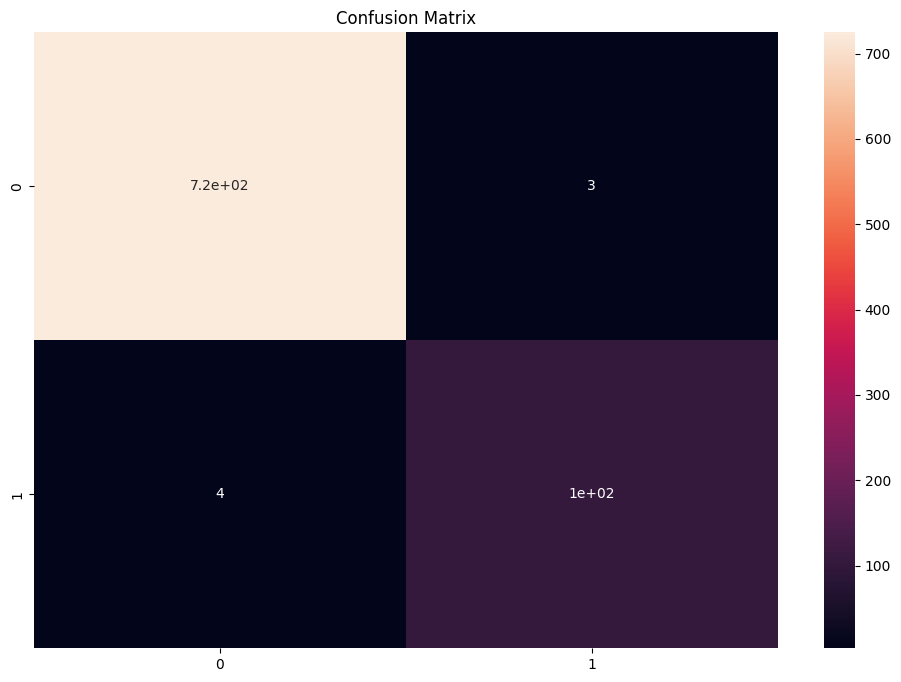

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

score = accuracy_score(y_test, y_pred)
print("Test Score:{:.2f}%".format(score*100))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

In [64]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, LSTM, Dense, Embedding, Bidirectional, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
data = pd.read_csv("spam.csv", encoding="latin")

# Rename columns
data = data.rename(columns={"v1": "Category", "v2": "Message"})

# Preprocess the text data
stemmer = PorterStemmer()
corpus = []
for message in data["Message"]:
    message = re.sub("[^a-zA-Z]", " ", message)
    message = message.lower()
    message = message.split()
    message = [stemmer.stem(word) for word in message if word not in set(
        stopwords.words("english"))]
    message = " ".join(message)
    corpus.append(message)

# Encode labels
label_encoder = LabelEncoder()
data["Category"] = label_encoder.fit_transform(data["Category"])

# Perform one-hot encoding for the text data
vocab_size = 10000
oneHot_doc = [one_hot(words, n=vocab_size) for words in corpus]

# Pad sequences to ensure uniform length
sentence_len = 200
embedded_doc = pad_sequences(oneHot_doc, maxlen=sentence_len, padding="pre")

# Split data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
    embedded_doc, data["Category"], random_state=42, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, random_state=42, test_size=0.15)

# Define the input layer
input_layer = tf.keras.Input(shape=(sentence_len,))

# Build the model
embedding_layer = Embedding(
    input_dim=vocab_size, output_dim=100, input_length=sentence_len)(input_layer)
bi_gru = Bidirectional(GRU(units=128, return_sequences=True))(embedding_layer)
bi_lstm = Bidirectional(
    LSTM(units=128, return_sequences=True))(embedding_layer)
lstm = LSTM(units=128)(bi_lstm)
# Reshape the output of BiGRU to match the shape of Flatten output
flatten = Flatten()(bi_gru)

# Concatenate the outputs of BiGRU and BiLSTM
concat = concatenate([flatten, lstm])

output_layer = Dense(units=1, activation="sigmoid")(concat)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/3
126/126 [==============================] - 147s 1s/step - loss: 0.1679 - accuracy: 0.9391 - val_loss: 0.0629 - val_accuracy: 0.9859
Epoch 2/3
126/126 [==============================] - 141s 1s/step - loss: 0.0272 - accuracy: 0.9925 - val_loss: 0.0646 - val_accuracy: 0.9902
Epoch 3/3
27/27 [==============================] - 5s 180ms/step - loss: 0.0413 - accuracy: 0.9916
Test Loss: 0.041271649301052094
Test Accuracy: 0.9916267991065979


27/27 [==============================] - 5s 194ms/step
Test Score:99.16%


array([[726,   2],
       [  5, 103]], dtype=int64)

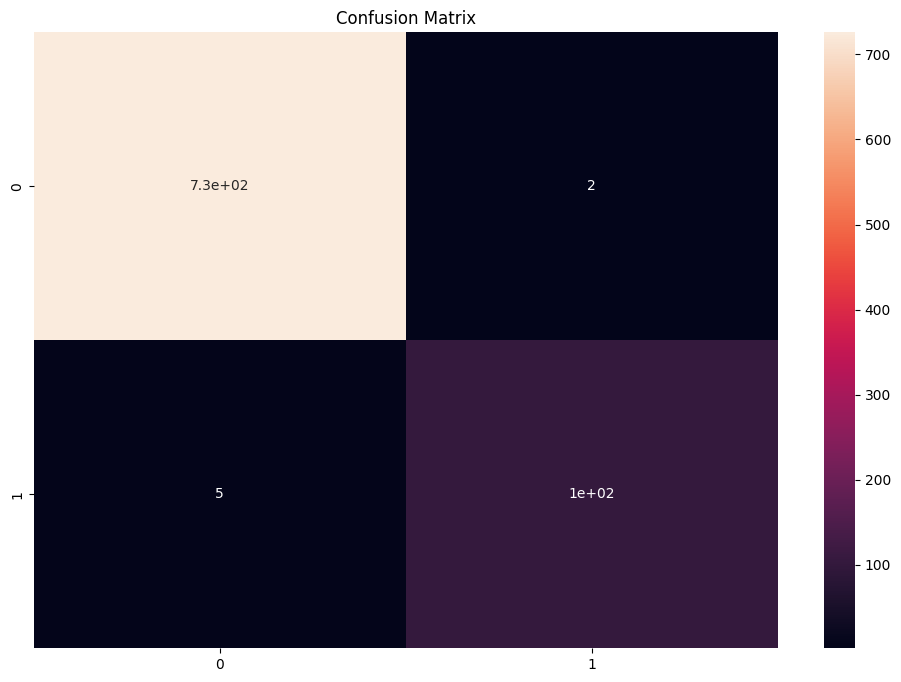

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

score = accuracy_score(y_test, y_pred)
print("Test Score:{:.2f}%".format(score*100))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

In [67]:
model.save("bi_lstm_gru.h5")

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 10000
sentence_len = 200


models = load_model("bi_lstm_gru.h5")

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 10000
sentence_len = 200

models = load_model("bi_lstm_gru.h5")
# The function take model and message as parameter


def classify_message(model, message):

    # We will treat message as a paragraphs containing multiple sentences(lines)

    # we will extract individual lines

    for sentences in message:

        sentences = nltk.sent_tokenize(message)

        # Iterate over individual sentences

        for sentence in sentences:

            # replace all special characters

            words = re.sub("[^a-zA-Z]", " ", sentence)

            # perform word tokenization of all non-english-stopwords

            if words not in set(stopwords.words('english')):

                word = nltk.word_tokenize(words)

                word = " ".join(word)

    # perform one_hot on tokenized word

    oneHot = [one_hot(word, n=vocab_size)]

    # create an embedded documnet using pad_sequences

    # this can be fed to our model

    text = pad_sequences(oneHot, maxlen=sentence_len, padding="pre")

    # predict the text using model

    predict = models.predict(text)

    # if predict value is greater than 0.5 its a spam

    # if predict > 0.5:

    #     print("It is a spam")

    # # else the message is not a spam

    # else:

    #     print("It is not a spam")

    return predict

In [13]:
text1 = "I am having a bad day and I would like to have a break today"
text2 = "This is to inform you had won a lottery and the subscription will end in a week so call us."

In [32]:
classify_message(models, text1)

1/1 [==============================] - 0s 243ms/step


array([[0.11855535]], dtype=float32)

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests

from bs4 import BeautifulSoup

from tensorflow.keras.models import load_model
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 10000
sentence_len = 200

models = load_model("bi_lstm_gru.h5")
# The function take model and message as parameter


def classify_message(model, message):

    # We will treat message as a paragraphs containing multiple sentences(lines)
    # we will extract individual lines
    for sentences in message:
        sentences = nltk.sent_tokenize(message)

        # Iterate over individual sentences
        for sentence in sentences:
            # replace all special characters
            words = re.sub("[^a-zA-Z]", " ", sentence)

            # perform word tokenization of all non-english-stopwords
            if words not in set(stopwords.words('english')):
                word = nltk.word_tokenize(words)
                word = " ".join(word)

    # perform one_hot on tokenized word
    oneHot = [one_hot(word, n=vocab_size)]

    # create an embedded documnet using pad_sequences
    # this can be fed to our model
    text = pad_sequences(oneHot, maxlen=sentence_len, padding="pre")

    # predict the text using model
    predict = models.predict(text)

    # if predict value is greater than 0.5 its a spam
    # if predict > 0.5:
    #     print("It is a spam")
    # # else the message is not a spam
    # else:
    #     print("It is not a spam")
    return predict


def scrape_website_text(url):

    # Send a GET request to the URL

    response = requests.get(url)

    # Check if the request was successful (status code 200)

    if response.status_code == 200:

        # Parse the HTML content of the page

        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all text elements in the HTML

        text_elements = soup.get_text()

        return text_elements

    else:
        print(

            f"Failed to retrieve content from {url}. Status code: {response.status_code}")

        return None


# Example usage
url = "https://flipkart.com"  # Replace with the URL of the website you want to scrape

website_text = scrape_website_text(url)

if website_text:

    print(website_text)

else:

    print("Failed to scrape website text.")

pa = website_text.split(". ")
print(pa)

spam = 0
notspam = 0
total = 0
for k in pa:
    v = classify_message(models, text1)[0][0]
    if v > 0.5:

        spam += 1
    # else the message is not a spam
    else:
        notspam += 1

    total += 1
print(spam, notspam, total)
to = notspam/total
print(to)


val = to*100
print(str(val)+"% safe to use")

  Online Shopping Site for Mobiles, Electronics, Furniture, Grocery, Lifestyle, Books & More. Best Offers!            
   Search IconLoginNew customer?Sign UpMy ProfileFlipkart Plus ZoneOrdersWishlistRewardsGift CardsLoginCartBecome a SellerNotification Preferences24x7 Customer CareAdvertiseDownload AppGroceryMobilesFashionElectronicsHome & FurnitureAppliancesTravelBeauty, Toys & MoreTwo WheelersBest Deals on SmartphonesiPhone 15incl of offersredmi 12 5Gincl of offersiphone 14incl of offerssamsung S23 FEincl of offersmoto edge 40 neoincl of offerssamsung s21 FEincl of offersrealme 12 proincl of offersinfinix smart 8incl of offersHang on, loading contentFlipkart - Your go-to place for Online Shopping+Flipkart: The One-stop Shopping DestinationE-commerce is revolutionizing the way we all shop in India. Why do you want to hop from one store to another in search of the latest phone when you can find it on the Internet in a single click? Not only mobiles. Flipkart houses everything you can 

['  Online Shopping Site for Mobiles, Electronics, Furniture, Grocery, Lifestyle, Books & More', 'Best Offers!            \n   Search IconLoginNew customer?Sign UpMy ProfileFlipkart Plus ZoneOrdersWishlistRewardsGift CardsLoginCartBecome a SellerNotification Preferences24x7 Customer CareAdvertiseDownload AppGroceryMobilesFashionElectronicsHome & FurnitureAppliancesTravelBeauty, Toys & MoreTwo WheelersBest Deals on SmartphonesiPhone 15incl of offersredmi 12 5Gincl of offersrealme 12 pro plusincl of offerssamsung S23 FEincl of offerssamsung s21 FEincl of offersrealme c53incl of offersvivo t2 proincl of offersmoto g34incl of offersHang on, loading contentFlipkart - Your go-to place for Online Shopping+Flipkart: The One-stop Shopping DestinationE-commerce is revolutionizing the way we all shop in India', 'Why do you want to hop from one store to another in search of the latest phone when you can find it on the Internet in a single click? Not only mobiles', 'Flipkart houses everything you c

1/1 [==============================] - 0s 70ms/step
0 73 73
1.0


In [30]:

val = to*100
print(str(val)+"% safe to use")

100.0% safe to use


In [104]:
import requests
from bs4 import BeautifulSoup


def scrape_website_text(url):
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all text elements in the HTML
        text_elements = soup.get_text()

        return text_elements
    else:
        print(
            f"Failed to retrieve content from {url}. Status code: {response.status_code}")
        return None


# Example usage
# Replace with the URL of the website you want to scrape
url = "https://www.spam.com/"
website_text = scrape_website_text(url)


spam = 0
notspam = 0
total = 0
for k in pa:
    v = classify_message(models, text1)[0][0]
    if v > 0.5:

        spam += 1
    # else the message is not a spam
    else:
        notspam += 1

    total += 1
print(spam, notspam, total)
to = notspam/total
print(to)

val = to*100
print(str(val)+"% safe to use")

1/1 [==============================] - 0s 43ms/step
0 2 2
1.0
100.0% safe to use
